# Multivariate Variational Mode Decomposition

# https://ieeexplore.ieee.org/document/8890883

In [1]:
def mvmd(signal, alpha, tau, K, DC, init, tol, max_N):
    # ---------------------
    #  signal  - the time domain signal (1D) to be decomposed
    #  alpha   - the balancing parameter of the data-fidelity constraint
    #  tau     - time-step of the dual ascent ( pick 0 for noise-slack )
    #  K       - the number of modes to be recovered
    #  DC      - true if the first mode is put and kept at DC (0-freq)
    #  init    - 0 = all omegas start at 0
    #                     1 = all omegas start uniformly distributed
    #                     2 = all omegas initialized randomly
    #  tol     - tolerance of convergence criterion; typically around 1e-6
    #
    #  Output:
    #  -------
    #  u       - the collection of decomposed modes
    #  u_hat   - spectra of the modes
    #  omega   - estimated mode center-frequencies
    #

    # import numpy as np
    # import math
    # import matplotlib.pyplot as plt
    import torch

    # Period and sampling frequency of input signal
    C, T = signal.shape # T:length of signal C:  channel number
    fs = 1 / float(T)

    # extend the signal by mirroring
    # T = save_T
    # print(T)
    f_mirror = torch.zeros(C, 2*T)
    #print(f_mirror)
    f_mirror[:,0:T//2] = torch.flip(signal[:,0:T//2], dims=[-1]) 
    # print(f_mirror)
    f_mirror[:,T//2:3*T//2] = signal
    # print(f_mirror)
    f_mirror[:,3*T//2:2*T] = torch.flip(signal[:,T//2:], dims=[-1])
    # print(f_mirror)
    f = f_mirror


    # Time Domain 0 to T (of mirrored signal)
    T = float(f.shape[1])
    # print(T)
    t = torch.linspace(1/float(T), 1, int(T))
    # print(t)

    # Spectral Domain discretization
    freqs = t - 0.5 - 1/T

    # Maximum number of iterations (if not converged yet, then it won't anyway)
    N = max_N

    # For future generalizations: individual alpha for each mode
    Alpha = alpha * torch.ones(K, dtype=torch.cfloat)

    # Construct and center f_hat
    f_hat = torch.fft.fftshift(torch.fft.fft(f))
    f_hat_plus = f_hat
    f_hat_plus[:, 0:int(int(T)/2)] = 0

    # matrix keeping track of every iterant // could be discarded for mem
    u_hat_plus = torch.zeros((N, len(freqs), K, C), dtype=torch.cfloat)

    # Initialization of omega_k
    omega_plus = torch.zeros((N, K), dtype=torch.cfloat)
                        
    if (init == 1):
        for i in range(1, K+1):
            omega_plus[0,i-1] = (0.5/K)*(i-1)
    elif (init==2):
        omega_plus[0,:] = torch.sort(torch.exp(torch.log(fs)) +
        (torch.log(0.5) - torch.log(fs)) * torch.random.rand(1, K))
    else:
        omega_plus[0,:] = 0

    if (DC):
        omega_plus[0,0] = 0


    # start with empty dual variables
    lamda_hat = torch.zeros((N, len(freqs), C), dtype=torch.cfloat)

    # other inits
    uDiff = tol+2.2204e-16 #updata step
    n = 1 #loop counter
    sum_uk = torch.zeros((len(freqs), C)) #accumulator

    T = int(T)

    # ----------- Main loop for iterative updates

    while uDiff > tol and n < N:
        # update first mode accumulator
        k = 1
        sum_uk = u_hat_plus[n-1,:,K-1,:] + sum_uk - u_hat_plus[n-1,:,0,:]

        #update spectrum of first mode through Wiener filter of residuals
        for c in range(C):
            u_hat_plus[n,:,k-1,c] = (f_hat_plus[c,:] - sum_uk[:,c] - 
            lamda_hat[n-1,:,c]/2) \
        / (1 + Alpha[k-1] * torch.square(freqs - omega_plus[n-1,k-1]))
   
        #update first omega if not held at 0
        if DC == False:
            omega_plus[n,k-1] = torch.sum(torch.mm(freqs[T//2:T].unsqueeze(0), 
                            torch.square(torch.abs(u_hat_plus[n,T//2:T,k-1,:])))) \
            / torch.sum(torch.square(torch.abs(u_hat_plus[n,T//2:T,k-1,:])))


        for k in range(2, K+1):

            #accumulator
            sum_uk = u_hat_plus[n,:,k-2,:] + sum_uk - u_hat_plus[n-1,:,k-1,:]

            #mode spectrum
            for c in range(C):
                u_hat_plus[n,:,k-1,c] = (f_hat_plus[c,:] - sum_uk[:,c] - 
            lamda_hat[n-1,:,c]/2) \
            / (1 + Alpha[k-1] * torch.square(freqs-omega_plus[n-1,k-1]))
    #         print('u_hat_plus'+str(k))
    #         print(u_hat_plus[n,:,k-1])
            
            #center frequencies
            omega_plus[n,k-1] = torch.sum(torch.mm(freqs[T//2:T].unsqueeze(0),
                torch.square(torch.abs(u_hat_plus[n,T//2:T,k-1,:])))) \
                /  torch.sum(torch.square(torch.abs(u_hat_plus[n,T//2:T:,k-1,:])))

        #Dual ascent
    #     print(u_hat_plus.shape) tau一般是0，这里不用管
        lamda_hat[n,:,:] = lamda_hat[n-1,:,:] # + tau * (torch.sum(u_hat_plus[n,:,:,:], dim=1)
                       #  - f_hat_plus)
    #     print('lamda_hat'+str(n))
    #     print(lamda_hat[n,:])

        #loop counter
        n = n + 1

        #converged yet?
        uDiff = 2.2204e-16

        for i in range(1, K+1):
            uDiff=uDiff+1 / float(T) * torch.mm(u_hat_plus[n-1,:,i-1,:] - u_hat_plus[n-2,:,i-1,:], 
                                                ((u_hat_plus[n-1,:,i-1,:]-u_hat_plus[n-2,:,i-1,:]).conj()).conj().T)
            
        uDiff = torch.sum(torch.abs(uDiff))

        
    # ------ Postprocessing and cleanup

    # discard empty space if converged early

    N = min(N, n)
    omega = omega_plus[0:N,:]

    # Signal reconstruction
    u_hat = torch.zeros((T,K,C), dtype=torch.cfloat)
    for c in range(C):
        u_hat[T//2:T,:,c] = torch.squeeze(u_hat_plus[N-1,T//2:T,:,c])
        # print('u_hat')
        # print(u_hat.shape)
        # print(u_hat)
        second_index = list(range(1,T//2+1))
        second_index.reverse()
        u_hat[second_index,:,c] = torch.squeeze(torch.conj(u_hat_plus[N-1,T//2:T,:,c]))
        u_hat[0,:,c] = torch.conj(u_hat[-1,:,c])
    # print('u_hat')
    # print(u_hat)
    u = torch.zeros((K,len(t),C), dtype=torch.cfloat)

    for k in range(1, K+1):
        for c in range(C):
            u[k-1,:,c]  = (torch.fft.ifft(torch.fft.ifftshift(u_hat[:,k-1,c]))).real


    # remove mirror part 
    u = u[:,T//4:3*T//4,:]

    # print(u_hat.shape)
    #recompute spectrum
    u_hat = torch.zeros((T//2,K,C), dtype=torch.cfloat)

    for k in range(1, K+1):
        for c in range(C):
            u_hat[:,k-1,c] = torch.fft.fftshift(torch.fft.fft(u[k-1,:,c])).conj()
    
    # ifftshift 
    u = torch.fft.ifftshift(u, dim=-1)
            
    
        
    return (u.real, u_hat, omega)

# data 

In [2]:
import scipy.io as sio
import numpy as np
import torch

# 加载数据
data_path = '/root/2025_1_14/data_samson_patch_3.mat'
mat_data = sio.loadmat(data_path)
hyperspectral_data = mat_data['data_samson_patch_3']  # (20449, 9, 156)

# PyTorch张量
hsi_tensor = torch.from_numpy(hyperspectral_data).float()  # [20449, 9, 156]
print("原始数据维度:", hsi_tensor.shape)  # (20449,9,156)

原始数据维度: torch.Size([20449, 9, 156])


In [3]:
def spectral_smoothing_mvmd(signal_1d, alpha=1200, K=4):
    """
    对单条光谱进行MVMD平滑
    Args:
        signal_1d: 单条光谱 [156]
        alpha: 控制模态带宽（值越大保留的高频越少）
        K: 分解模态数
    Returns:
        smoothed_spectrum: 平滑后的光谱 [156]
    """
    # MVMD输入格式 [通道数C=1, 信号长度T=156]
    signal = signal_1d.unsqueeze(0)  # [1, 156]
    
    # MVMD分解
    u_real, _, omega = mvmd(
        signal=signal,
        alpha=alpha,
        tau=0,
        K=K,
        DC=True,
        init=1,
        tol=1e-6,
        max_N=700
    )
    
    # 选择尖峰的模态:最后一个模态
    peak_mode = u_real[-1, :, 0]  # [T]
    smooth_modes = torch.sum(u_real[:-1, :, 0], dim=0)  # 其他模态求和
    
    # 重构信号（保留尖峰+平滑背景）
    return smooth_modes + 0.5 * peak_mode  # 权重

In [4]:
from tqdm import tqdm

def batch_smooth(hsi_tensor, alpha=1200, K=4):
    """
    批量处理所有空间位置和邻域像素
    Args:
        hsi_tensor: 原始高光谱数据 [20449,9,156]
        alpha: MVMD参数
        K: 模态数
    Returns:
        smoothed_hsi: 平滑后的数据 [20449,9,156]
    """
    smoothed_hsi = torch.zeros_like(hsi_tensor)
    
    # 遍历空间位置 (20449)
    for i in tqdm(range(hsi_tensor.shape[0])):
        # 遍历邻域像素 (9)
        for j in range(hsi_tensor.shape[1]):
            spectrum = hsi_tensor[i, j, :]  # [156]
            smoothed = spectral_smoothing_mvmd(spectrum, alpha, K)
            smoothed_hsi[i, j, :] = smoothed
            
    return smoothed_hsi

# 执行平滑
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
smoothed_data = batch_smooth(hsi_tensor.to(device), alpha=1200, K=4)
smoothed_data = smoothed_data.cpu().numpy()  # 

100%|██████████| 20449/20449 [11:21:11<00:00,  2.00s/it]  


In [6]:
# sio.savemat('smoothed_samson.mat', 
#             {'data_smoothed': smoothed_data, 
#              'params': {'alpha': 1000, 'K': 3}})

In [5]:
sio.savemat('smoothed_samson_K4.mat', 
            {'data_smoothed': smoothed_data})

In [22]:
import scipy.io as sio
import numpy as np

# 加载MAT文件
data_path = '/root/2025_1_14/MVMD/smoothed_samson_K4.mat'
mat_data = sio.loadmat(data_path)

# 检查所有可用键
print("Keys in .mat file:", mat_data.keys())  #  'data_smoothed'

# 提取正确的键
hyperspectral_data = mat_data['data_smoothed']  # `data_smoothed`
print("Shape of smoothed data:", hyperspectral_data.shape)

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'data_smoothed'])
Shape of smoothed data: (20449, 9, 156)


# view

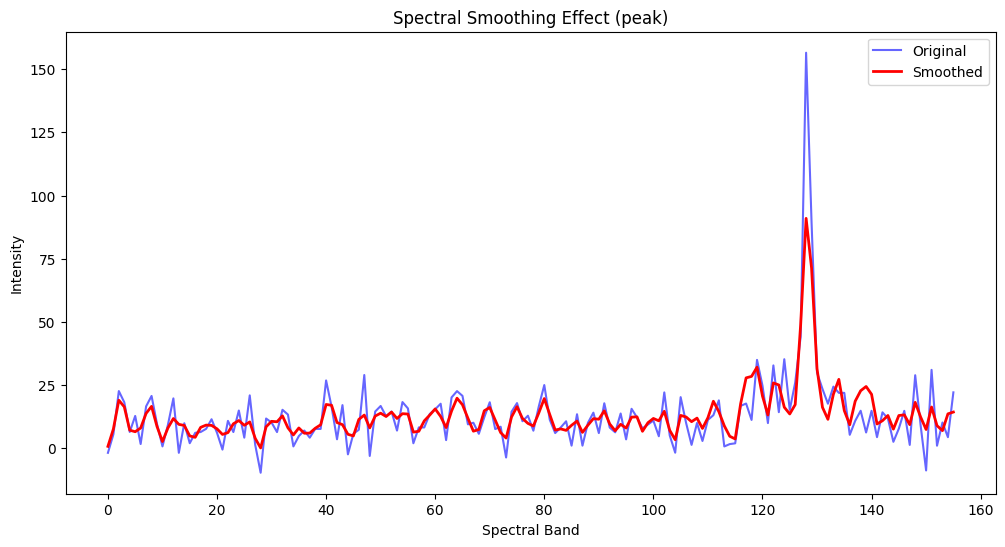

In [30]:
import matplotlib.pyplot as plt

pos_idx = np.random.randint(0, 20449)
pixel_idx = np.random.randint(0, 9)

original = hsi_tensor[pos_idx, pixel_idx, :].numpy()
smoothed = smoothed_data[pos_idx, pixel_idx, :]

plt.figure(figsize=(12,6))
plt.plot(original, 'b', alpha=0.6, label='Original')
plt.plot(smoothed, 'r', lw=2, label='Smoothed')
plt.xlabel('Spectral Band')
plt.ylabel('Intensity')
plt.legend()
plt.title('Spectral Smoothing Effect (peak)')
plt.show()

In [29]:
import numpy as np

# 保存变量
save_path = "/root/2025_1_14/MVMD/visualization_data.npz"
np.savez(
    save_path,
    original_data=original,  # 原始光谱数据
    smoothed_data=smoothed,   # 平滑后的光谱数据
    pos_idx=pos_idx,          # 随机选取的空间位置索引
    pixel_idx=pixel_idx,      # 邻域像素索引
)

print(f"数据已保存至 {save_path}")

数据已保存至 /root/2025_1_14/MVMD/visualization_data.npz


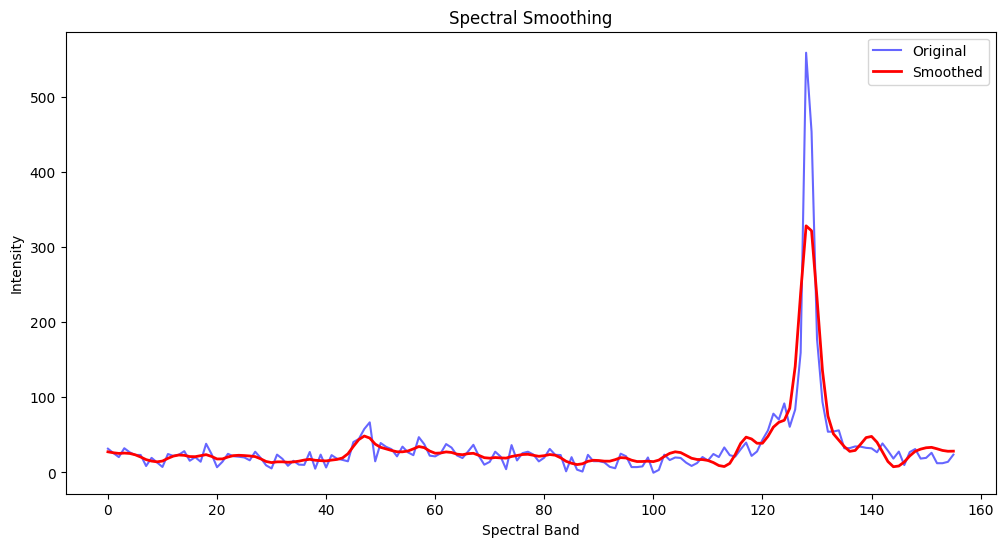

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
data = np.load("/root/2025_1_14/MVMD/visualization_data.npz")

# 提取变量
original = data['original_data']
smoothed = data['smoothed_data']
pos_idx = data['pos_idx']
pixel_idx = data['pixel_idx']

# 直接绘图
plt.figure(figsize=(12,6))
plt.plot(original, 'b', alpha=0.6, label='Original')
plt.plot(smoothed, 'r', lw=2, label='Smoothed')
plt.xlabel('Spectral Band')
plt.ylabel('Intensity')
plt.legend()
plt.title(f'Spectral Smoothing') 
plt.show()